In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import math
from numpy import genfromtxt
import png
from numpy import genfromtxt
from PIL import Image    
from matplotlib.colors import ListedColormap
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from scipy import stats

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(filename='Ventus.wav', autoplay=True))
## Insert whatever audio file you want above

In [2]:
# Read in csv
df = pd.read_csv('age_gender.csv')

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


# Step 1: Data Cleaning

In [3]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32))

In [4]:
df = df[df.age <= 75]
df = df.reset_index(drop=True)

In [5]:
df['age_group_i'] = pd.cut(df.age, [0, 25, 50, 75], labels= [1, 2, 3])

In [6]:
conditions = [
    (df["age_group_i"] == 1) & (df['gender'] == 1),
    (df["age_group_i"] == 2) & (df['gender'] == 1),
    (df["age_group_i"] == 3) & (df['gender'] == 1),
    (df["age_group_i"] == 1) & (df['gender'] == 0),
    (df["age_group_i"] == 2) & (df['gender'] == 0),
    (df["age_group_i"] == 3) & (df['gender'] == 0)
]

choices = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO']

df['class'] = np.select(conditions, choices)

In [7]:
df = df.drop(columns = ['ethnicity', 'img_name'])

In [8]:
df.isna().sum()

age            0
gender         0
pixels         0
age_group_i    0
class          0
dtype: int64

In [9]:
# Aesthetics
sns.set_style("whitegrid")

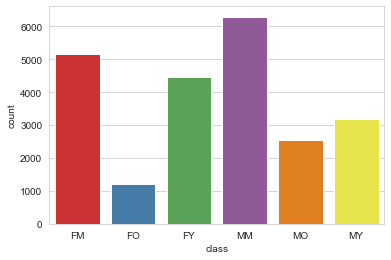

In [10]:
sns.countplot(df['class'].sort_values(), palette="Set1")

In [11]:
len(df)

22854

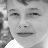

In [12]:
image = Image.fromarray((df.pixels[22853].reshape(48,48)).astype(np.uint8))

image.convert('RGB')

In [13]:
col_names = []
for i in range(0,48):
    for j in range(0,48):
        col_names.append('r'+str(i)+'c'+str(j))

df[col_names] = pd.DataFrame(df.pixels.tolist(), index= df.index, columns = col_names)

# Step 2: Discriminating Power, Standardization, and Correlation Matrix

In [14]:
select_feat = ['r18c23','r19c24','r23c6','r14c30','r5c12','class']

In [15]:
class_set = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO']

In [16]:
select_df = df[select_feat]

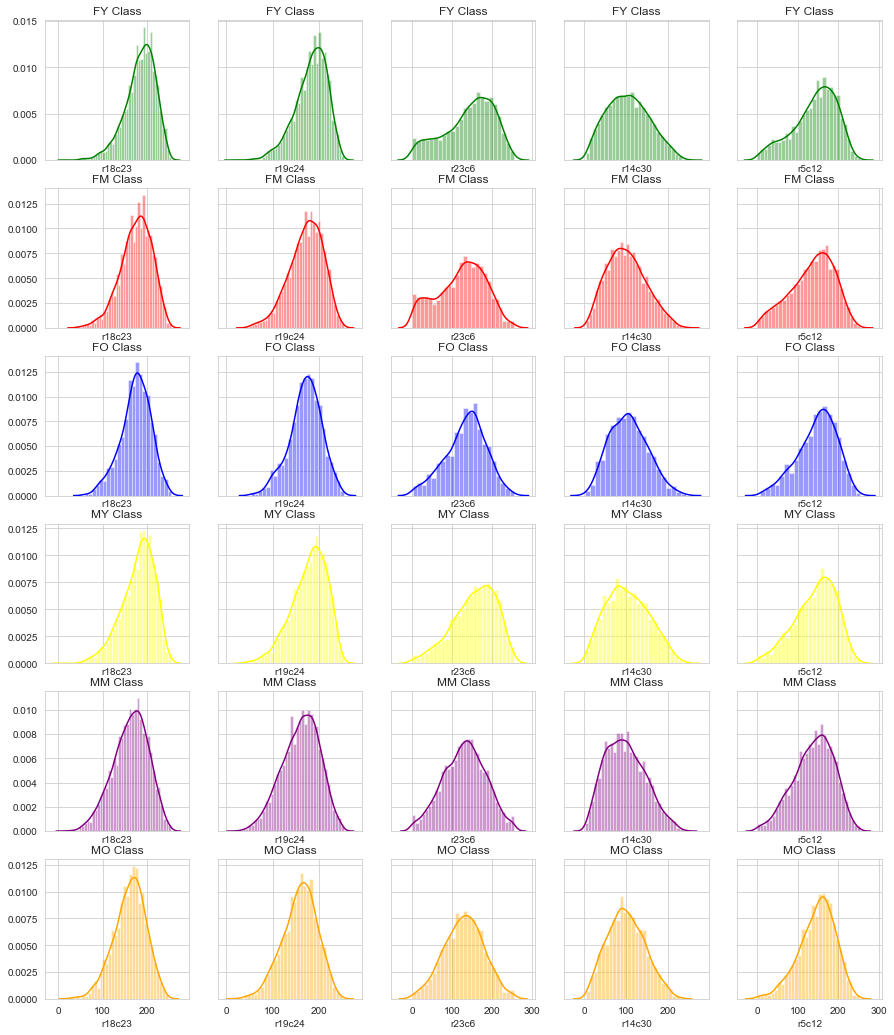

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (15,18), sharex='col', sharey='row')


for i, column in enumerate(select_df.columns[:5]):
    sns.distplot(select_df[select_df['class'] == 'FY'][column], ax = axes[0,i], color = 'green').set_title('FY Class')
    sns.distplot(select_df[select_df['class'] == 'FM'][column], ax = axes[1,i], color = 'red').set_title('FM Class')
    sns.distplot(select_df[select_df['class'] == 'FO'][column], ax = axes[2,i], color = 'blue').set_title('FO Class')
    sns.distplot(select_df[select_df['class'] == 'MY'][column], ax = axes[3,i], color = 'yellow').set_title('MY Class')
    sns.distplot(select_df[select_df['class'] == 'MM'][column], ax = axes[4,i], color = 'purple').set_title('MM Class')
    sns.distplot(select_df[select_df['class'] == 'MO'][column], ax = axes[5,i], color = 'orange').set_title('MO Class')

In [18]:
# KS-test to Compare Histograms Between Pairs of Classes
 #   Null hypotheses: Two group histograms are equal
 #   Alternative hypotheses: Two group histograms are different (two-tailed)

KS_test_results_1_2 = {}
KS_test_results_1_3 = {}
KS_test_results_1_4 = {}
KS_test_results_1_5 = {}
KS_test_results_1_6 = {}
KS_test_results_2_3 = {}
KS_test_results_2_4 = {}
KS_test_results_2_5 = {}
KS_test_results_2_6 = {}
KS_test_results_3_4 = {}
KS_test_results_3_5 = {}
KS_test_results_3_6 = {}
KS_test_results_4_5 = {}
KS_test_results_4_6 = {}
KS_test_results_5_6 = {}
 
# loop over column_list and execute code explained above
for column in select_df.columns[:5]:
    groupFY = select_df[select_df['class'] == 'FY'][column]
    groupFM = select_df[select_df['class'] == 'FM'][column]
    groupFO = select_df[select_df['class'] == 'FO'][column]
    groupMY = select_df[select_df['class'] == 'MY'][column]
    groupMM = select_df[select_df['class'] == 'MM'][column]
    groupMO = select_df[select_df['class'] == 'MO'][column]
    # add the output to the dictionary  
    KS_test_results_1_2[column] = stats.ks_2samp(groupFY,groupFM)
    KS_test_results_1_3[column] = stats.ks_2samp(groupFY,groupFO)
    KS_test_results_1_4[column] = stats.ks_2samp(groupFY,groupMY)
    KS_test_results_1_5[column] = stats.ks_2samp(groupFY,groupMM)
    KS_test_results_1_6[column] = stats.ks_2samp(groupFY,groupMO)
    KS_test_results_2_3[column] = stats.ks_2samp(groupFM,groupFO)
    KS_test_results_2_4[column] = stats.ks_2samp(groupFM,groupMY)
    KS_test_results_2_5[column] = stats.ks_2samp(groupFM,groupMM)
    KS_test_results_2_6[column] = stats.ks_2samp(groupFM,groupMO)
    KS_test_results_3_4[column] = stats.ks_2samp(groupFO,groupMY)
    KS_test_results_3_5[column] = stats.ks_2samp(groupFO,groupMM)
    KS_test_results_3_6[column] = stats.ks_2samp(groupFO,groupMO)
    KS_test_results_4_5[column] = stats.ks_2samp(groupMY,groupMM)
    KS_test_results_4_6[column] = stats.ks_2samp(groupMY,groupMO)
    KS_test_results_5_6[column] = stats.ks_2samp(groupMM,groupMO)
 

    # KS Test
KS_results_df_1_2 = pd.DataFrame.from_dict(KS_test_results_1_2,orient='Index')
KS_results_df_1_2.columns = ['KS statistic for Group FY & FM','pvalue for Group FY & FM']
KS_results_df_1_3 = pd.DataFrame.from_dict(KS_test_results_1_3,orient='Index')
KS_results_df_1_3.columns = ['KS statistic for Group FY & FO','pvalue for Group FY & FO']
KS_results_df_1_4 = pd.DataFrame.from_dict(KS_test_results_1_4,orient='Index')
KS_results_df_1_4.columns = ['KS statistic for Group FY & MY','pvalue for Group FY & MY']
KS_results_df_1_5 = pd.DataFrame.from_dict(KS_test_results_1_5,orient='Index')
KS_results_df_1_5.columns = ['KS statistic for Group FY & MM','pvalue for Group FY & MM']
KS_results_df_1_6 = pd.DataFrame.from_dict(KS_test_results_1_6,orient='Index')
KS_results_df_1_6.columns = ['KS statistic for Group FY & MO','pvalue for Group FY & MO']
KS_results_df_2_3 = pd.DataFrame.from_dict(KS_test_results_2_3,orient='Index')
KS_results_df_2_3.columns = ['KS statistic for Group FM & FO','pvalue for Group FM & FO']
KS_results_df_2_4 = pd.DataFrame.from_dict(KS_test_results_2_4,orient='Index')
KS_results_df_2_4.columns = ['KS statistic for Group FM & MY','pvalue for Group FM & MY']
KS_results_df_2_5 = pd.DataFrame.from_dict(KS_test_results_2_5,orient='Index')
KS_results_df_2_5.columns = ['KS statistic for Group FM & MM','pvalue for Group FM & MM']
KS_results_df_2_6 = pd.DataFrame.from_dict(KS_test_results_2_6,orient='Index')
KS_results_df_2_6.columns = ['KS statistic for Group FM & MO','pvalue for Group FM & MO']
KS_results_df_3_4 = pd.DataFrame.from_dict(KS_test_results_3_4,orient='Index')
KS_results_df_3_4.columns = ['KS statistic for Group FO & MY','pvalue for Group FO & MY']
KS_results_df_3_5 = pd.DataFrame.from_dict(KS_test_results_3_5,orient='Index')
KS_results_df_3_5.columns = ['KS statistic for Group FO & MM','pvalue for Group FO & MM']
KS_results_df_3_6 = pd.DataFrame.from_dict(KS_test_results_3_6,orient='Index')
KS_results_df_3_6.columns = ['KS statistic for Group FO & MO','pvalue for Group FO & MO']
KS_results_df_4_5 = pd.DataFrame.from_dict(KS_test_results_4_5,orient='Index')
KS_results_df_4_5.columns = ['KS statistic for Group MY & MM','pvalue for Group MY & MM']
KS_results_df_4_6 = pd.DataFrame.from_dict(KS_test_results_4_6,orient='Index')
KS_results_df_4_6.columns = ['KS statistic for Group MY & MO','pvalue for Group MY & MO']
KS_results_df_5_6 = pd.DataFrame.from_dict(KS_test_results_5_6,orient='Index')
KS_results_df_5_6.columns = ['KS statistic for Group MM & MO','pvalue for Group MM & MO']

 
KS_test_Results_df = pd.concat([KS_results_df_1_2, 
                                KS_results_df_1_3, 
                                KS_results_df_1_4,
                                KS_results_df_1_5,
                                KS_results_df_1_6,
                                KS_results_df_2_3,
                                KS_results_df_2_4,
                                KS_results_df_2_5,
                                KS_results_df_2_6,
                                KS_results_df_3_4,
                                KS_results_df_3_5,
                                KS_results_df_3_6,
                                KS_results_df_4_5,
                                KS_results_df_4_6,
                                KS_results_df_5_6], axis=1)
KS_test_Results_df
 
# Discrimnation Power based of KS Results
pow12 = 1 - KS_test_Results_df.iloc[:,1]
pow13 = 1 - KS_test_Results_df.iloc[:,3]
pow14 = 1 - KS_test_Results_df.iloc[:,5]
pow15 = 1 - KS_test_Results_df.iloc[:,7]
pow16 = 1 - KS_test_Results_df.iloc[:,9]
pow23 = 1 - KS_test_Results_df.iloc[:,11]
pow24 = 1 - KS_test_Results_df.iloc[:,13]
pow25 = 1 - KS_test_Results_df.iloc[:,15]
pow26 = 1 - KS_test_Results_df.iloc[:,17]
pow34 = 1 - KS_test_Results_df.iloc[:,19]
pow35 = 1 - KS_test_Results_df.iloc[:,21]
pow36 = 1 - KS_test_Results_df.iloc[:,23]
pow45 = 1 - KS_test_Results_df.iloc[:,25]
pow46 = 1 - KS_test_Results_df.iloc[:,27]
pow56 = 1 - KS_test_Results_df.iloc[:,29]
 
Discrim_Power = pd.concat([pow12, 
                           pow13, 
                           pow14, 
                           pow15, 
                           pow16, 
                           pow23,
                           pow24,
                           pow25,
                           pow26,
                           pow35,
                           pow36,
                           pow45,
                           pow46,
                           pow56], axis=1)
# Discrim_Power.columns = ['KS - Discriminating Power of Group FY & FM', 'KS - Discriminating Power of Group FY & FO', 'KS - Discriminating Power of Group FM & FO']

In [19]:
KS_test_Results_df

,KS statistic for Group FY & FM,pvalue for Group FY & FM,KS statistic for Group FY & FO,pvalue for Group FY & FO,KS statistic for Group FY & MY,pvalue for Group FY & MY,KS statistic for Group FY & MM,pvalue for Group FY & MM,KS statistic for Group FY & MO,pvalue for Group FY & MO,...,KS statistic for Group FO & MM,pvalue for Group FO & MM,KS statistic for Group FO & MO,pvalue for Group FO & MO,KS statistic for Group MY & MM,pvalue for Group MY & MM,KS statistic for Group MY & MO,pvalue for Group MY & MO,KS statistic for Group MM & MO,pvalue for Group MM & MO
r18c23,0.122252,2.997602e-15,0.155031,3.330669e-16,0.060174,2.771141e-06,0.250363,9.558254e-145,0.288139,2.442491e-15,...,0.145829,3.153538e-19,0.159494,0.000000,0.201760,4.773959e-15,0.246914,4.329870e-15,0.048746,3.440639e-04
r19c24,0.141299,2.997602e-15,0.180259,3.330669e-16,0.056223,1.533314e-05,0.249474,1.043339e-143,0.291012,2.442491e-15,...,0.141816,3.332048e-18,0.143980,0.000000,0.201474,4.773959e-15,0.249424,4.329870e-15,0.055534,2.615041e-05
r23c6,0.162511,2.997602e-15,0.164751,3.330669e-16,0.089620,2.046141e-13,0.165600,4.529732e-63,0.189421,2.442491e-15,...,0.060713,1.099173e-03,0.072925,0.000310,0.218193,4.773959e-15,0.241739,4.329870e-15,0.035217,2.153244e-02
r14c30,0.055123,9.060018e-07,0.050143,1.625822e-02,0.021787,3.358617e-01,0.070181,1.236844e-11,0.065419,1.740551e-06,...,0.087504,3.442743e-07,0.058560,0.006941,0.058138,1.208681e-06,0.067726,4.358776e-06,0.052488,8.663671e-05
r5c12,0.061434,2.649554e-08,0.048692,2.137197e-02,0.027235,1.246887e-01,0.061684,4.373664e-09,0.069633,2.727398e-07,...,0.092960,4.651756e-08,0.028920,0.489056,0.056484,2.695988e-06,0.061124,4.873074e-05,0.086158,3.580802e-12


In [20]:
Discrim_Power

,pvalue for Group FY & FM,pvalue for Group FY & FO,pvalue for Group FY & MY,pvalue for Group FY & MM,pvalue for Group FY & MO,pvalue for Group FM & FO,pvalue for Group FM & MY,pvalue for Group FM & MM,pvalue for Group FM & MO,pvalue for Group FO & MM,pvalue for Group FO & MO,pvalue for Group MY & MM,pvalue for Group MY & MO,pvalue for Group MM & MO
r18c23,1.000000,1.000000,0.999997,1.0,1.000000,0.921868,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999656
r19c24,1.000000,1.000000,0.999985,1.0,1.000000,0.991859,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999974
r23c6,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.998901,0.999690,1.000000,1.000000,0.978468
r14c30,0.999999,0.983742,0.664138,1.0,0.999998,0.999199,0.999966,0.999910,0.557798,1.000000,0.993059,0.999999,0.999996,0.999913
r5c12,1.000000,0.978628,0.875311,1.0,1.000000,1.000000,0.999999,0.999908,1.000000,1.000000,0.510944,0.999997,0.999951,1.000000


In [21]:
X = df.iloc[:,5:]

y = df.iloc[:,4]

In [22]:
X_classi = []

for i in class_set:
    X_classi.append(df[df['class'] == i].iloc[:,5:])
 
 

In [23]:
sXi = []
for i in X_classi:
    scaler = StandardScaler()
    scaler.fit(i)
    sXi.append(pd.DataFrame(scaler.transform(i), columns = col_names))

In [24]:
sXi_corr =[]

for i in sXi:
    sXi_corr.append(i.corr())

In [25]:
corr_frames = []
for i in sXi_corr:
    corr_frames.append(pd.DataFrame(i.unstack().sort_values(kind = 'quicksort', ascending=False).drop_duplicates()[1:5]))

In [26]:
corr_frames[0]

,,0
r18c23,r19c23,0.990086
r25c40,r24c40,0.989946
r24c39,r25c39,0.989869
r23c6,r22c6,0.989400


In [27]:
corr_frames[1]

,,0
r19c24,r18c24,0.990601
r20c24,r19c24,0.990049
r19c23,r18c23,0.989851
r22c6,r23c6,0.989407


In [28]:
corr_frames[2]

,,0
r20c33,r20c34,0.989191
r21c13,r21c14,0.987849
r24c38,r25c38,0.987644
r19c33,r19c34,0.987560


In [29]:
corr_frames[3]

,,0
r24c9,r25c9,0.989326
r18c5,r19c5,0.989144
r21c34,r21c33,0.989105
r25c9,r26c9,0.988750


In [30]:
corr_frames[4]

,,0
r2c22,r2c23,0.991728
r1c24,r1c23,0.991722
r1c23,r1c22,0.991094
r1c25,r1c24,0.991063


In [31]:
corr_frames[5]

,,0
r0c21,r0c20,0.989721
r1c26,r1c27,0.989500
r0c29,r0c28,0.989331
r0c26,r0c25,0.989071


In [32]:
scaler = StandardScaler()
scaler.fit(X)
sX = scaler.transform(X)
sX = pd.DataFrame(sX, columns = col_names)

In [33]:
sX_corr = sX.corr()

In [34]:
pd.DataFrame(sX_corr.unstack().sort_values(kind = 'quicksort', ascending=False).drop_duplicates()[1:11])

,,0
r18c23,r19c23,0.988014
r19c24,r18c24,0.987639
r23c6,r22c6,0.987603
r24c39,r25c39,0.987550
r22c41,r23c41,0.987213
r23c40,r22c40,0.987059
r24c39,r23c39,0.987020
r24c38,r25c38,0.986865
r24c7,r25c7,0.986711
r24c37,r25c37,0.986647


In [35]:
sX = pd.concat([sX, df.iloc[:,0:2]], axis=1)

# Step 3: Balance Dataset by Undersample

In [36]:
rus = RandomUnderSampler(random_state=0, sampling_strategy = 'not minority')
sX_res, y_res = rus.fit_resample(sX, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'FM': 1205, 'FO': 1205, 'FY': 1205, 'MM': 1205, 'MO': 1205, 'MY': 1205})


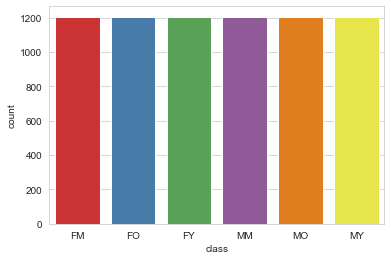

In [37]:
sns.countplot(y_res, palette = 'Set1')

In [38]:
sres_df = pd.DataFrame(sX_res)
sres_df['class'] = y_res
len(sres_df)

7230

# Step 4: Split Train and Test Set

In [39]:
# train and test split
sXFY_train, sXFY_test, clFY_train, clFY_test = train_test_split(sres_df[sres_df['class'] == 'FY'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FY'].iloc[:,2306], test_size=0.2, random_state=0)
sXFM_train, sXFM_test, clFM_train, clFM_test = train_test_split(sres_df[sres_df['class'] == 'FM'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FM'].iloc[:,2306], test_size=0.2, random_state=0)
sXFO_train, sXFO_test, clFO_train, clFO_test = train_test_split(sres_df[sres_df['class'] == 'FO'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FO'].iloc[:,2306], test_size=0.2, random_state=0)
sXMY_train, sXMY_test, clMY_train, clMY_test = train_test_split(sres_df[sres_df['class'] == 'MY'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MY'].iloc[:,2306], test_size=0.2, random_state=0)
sXMM_train, sXMM_test, clMM_train, clMM_test = train_test_split(sres_df[sres_df['class'] == 'MM'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MM'].iloc[:,2306], test_size=0.2, random_state=0)
sXMO_train, sXMO_test, clMO_train, clMO_test = train_test_split(sres_df[sres_df['class'] == 'MO'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MO'].iloc[:,2306], test_size=0.2, random_state=0)

In [40]:
X_train = pd.concat([sXFY_train, sXFM_train, sXFO_train, sXMY_train, sXMM_train, sXMO_train]) 
X_test = pd.concat([sXFY_test, sXFM_test, sXFO_test, sXMY_test, sXMM_test, sXMO_test])
y_train = pd.concat([clFY_train, clFM_train, clFO_train, clMY_train, clMM_train, clMO_train])
y_test = pd.concat([clFY_test, clFM_test, clFO_test, clMY_test, clMM_test, clMO_test])

In [41]:
len(sXFM_train)

964

In [42]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

5784 1446 5784 1446


# Step 5: Apply KNN Models

In [43]:
k = [10,30,50,70,90,110]

y_pred_train_ki = []
y_pred_test_ki = []

for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    y_pred_train_ki.append(classifier.predict(X_train))
    y_pred_test_ki.append(classifier.predict(X_test))

In [44]:
train_perf_k = []
test_perf_k = []

for i in y_pred_train_ki:
    train_perf_k.append(accuracy_score(y_true = y_train, y_pred = i))
for i in y_pred_test_ki:
    test_perf_k.append(accuracy_score(y_true = y_test, y_pred = i))

In [45]:
train_perf_k

[0.5264522821576764,
 0.45919778699861685,
 0.43309128630705396,
 0.41856846473029047,
 0.4088865836791148,
 0.39557399723374825]

In [46]:
test_perf_k

[0.37828492392807744,
 0.40802213001383125,
 0.40110650069156295,
 0.3948824343015214,
 0.38450899031811897,
 0.38035961272475793]

(10, 110)

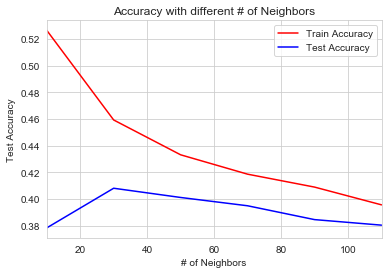

In [47]:
sns.lineplot(x = k, y = train_perf_k, color = 'red', label = "Train Accuracy")
sns.lineplot(x = k, y = test_perf_k, color = 'blue', label = "Test Accuracy")

plt.title('Accuracy with different # of Neighbors')
plt.xlabel('# of Neighbors')
plt.ylabel('Test Accuracy')
plt.xlim(10, 110)

In [48]:
k = [100,105,110,115,120,125]

y_pred_train_ki = []
y_pred_test_ki = []

for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    y_pred_train_ki.append(classifier.predict(X_train))
    y_pred_test_ki.append(classifier.predict(X_test))

In [49]:
train_perf_k = []
test_perf_k = []

for i in y_pred_train_ki:
    train_perf_k.append(accuracy_score(y_true = y_train, y_pred = i))
for i in y_pred_test_ki:
    test_perf_k.append(accuracy_score(y_true = y_test, y_pred = i))

In [50]:
train_perf_k

[0.4002420470262794,
 0.39851313969571234,
 0.39557399723374825,
 0.39349930843706776,
 0.39349930843706776,
 0.3943637621023513]

In [51]:
test_perf_k

[0.3852005532503458,
 0.3796680497925311,
 0.38035961272475793,
 0.3817427385892116,
 0.38105117565698476,
 0.38105117565698476]

In [52]:
for i in range(0,len(train_perf_k)):
    print(train_perf_k[i] - test_perf_k[i])

0.015041493775933612
0.018845089903181234
0.01521438450899032
0.011756569847856169
0.012448132780082999
0.013312586445366537


(100, 125)

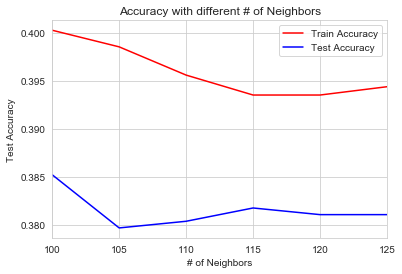

In [53]:
sns.lineplot(x = k, y = train_perf_k, color = 'red', label = "Train Accuracy")
sns.lineplot(x = k, y = test_perf_k, color = 'blue', label = "Test Accuracy")

plt.title('Accuracy with different # of Neighbors')
plt.xlabel('# of Neighbors')
plt.ylabel('Test Accuracy')
plt.xlim(100, 125)

In [54]:
y_pred_train_ki[3]

array(['MY', 'MY', 'FM', ..., 'MY', 'MO', 'MO'], dtype=object)

In [55]:
train_perf_k[3]

0.39349930843706776

# Step 6: Confusion Matrices

In [56]:
cmtx_a_train = pd.DataFrame(
    confusion_matrix(y_true=y_train,y_pred = y_pred_train_ki[3], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

In [57]:
cmtx_a_train

,pred:FY,pred:FM,pred:FO,pred:MY,pred:MM,pred:MO
true:FY,0.117220,0.279046,0.264523,0.212656,0.041494,0.085062
true:FM,0.059129,0.401452,0.295643,0.062241,0.052905,0.128631
true:FO,0.016598,0.141079,0.545643,0.051867,0.035270,0.209544
true:MY,0.041494,0.067427,0.189834,0.380705,0.121369,0.199170
true:MM,0.017635,0.090249,0.132780,0.065353,0.279046,0.414938
true:MO,0.003112,0.044606,0.181535,0.039419,0.094398,0.636929


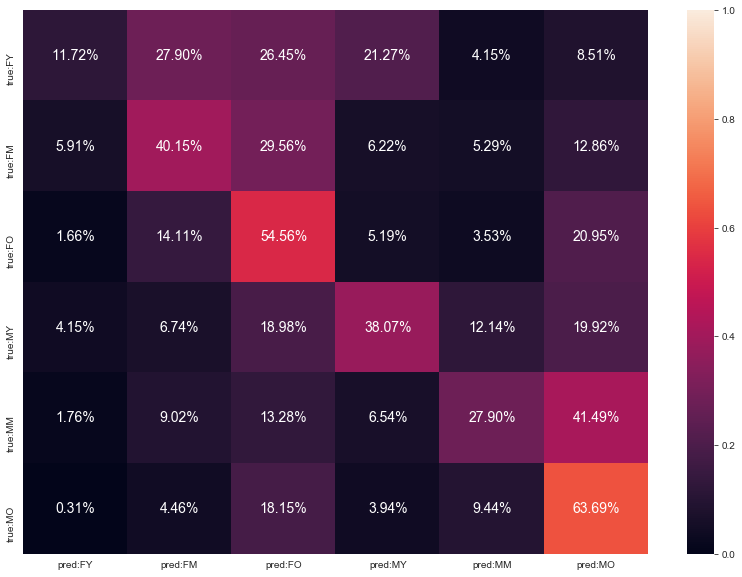

In [58]:
fig = plt.subplots(figsize = (14,10))

sns.heatmap(cmtx_a_train, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [59]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_test_ki[3], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

In [60]:
cmtx_a_test

,pred:FY,pred:FM,pred:FO,pred:MY,pred:MM,pred:MO
true:FY,0.082988,0.298755,0.294606,0.165975,0.053942,0.103734
true:FM,0.058091,0.410788,0.269710,0.053942,0.045643,0.161826
true:FO,0.029046,0.149378,0.502075,0.049793,0.033195,0.236515
true:MY,0.024896,0.087137,0.199170,0.402490,0.107884,0.178423
true:MM,0.008299,0.058091,0.141079,0.070539,0.265560,0.456432
true:MO,0.004149,0.033195,0.178423,0.041494,0.116183,0.626556


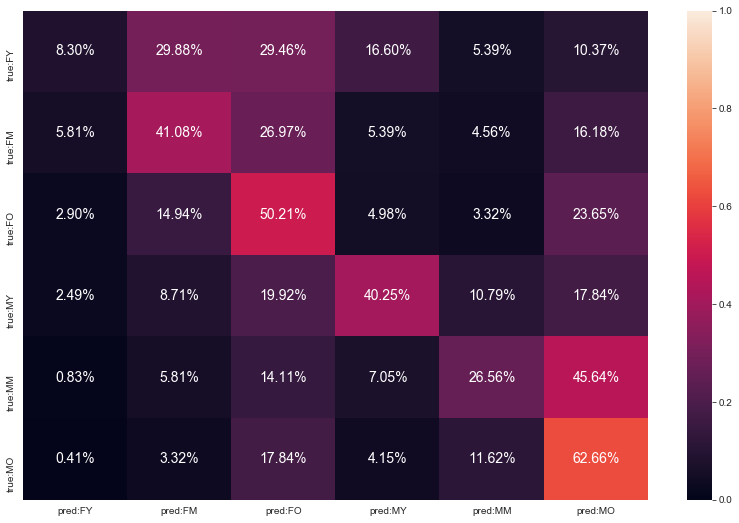

In [61]:
fig = plt.subplots(figsize = (14,9))

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

# Step 7: Resample by Over Sampling

In [62]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 'not majority')
sX_res, y_res = ros.fit_resample(sX, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'MY': 6296, 'FY': 6296, 'FM': 6296, 'MM': 6296, 'FO': 6296, 'MO': 6296})


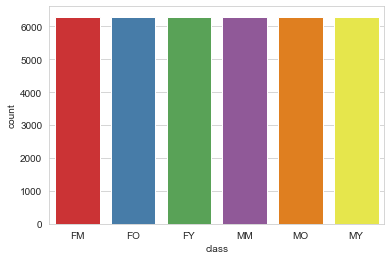

In [63]:
sns.countplot(y_res.sort_values(), palette = 'Set1')

In [64]:
sres_df = pd.DataFrame(sX_res)
sres_df['class'] = y_res
len(sres_df)

37776

In [65]:
# train and test split
sXFY_train, sXFY_test, clFY_train, clFY_test = train_test_split(sres_df[sres_df['class'] == 'FY'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FY'].iloc[:,2306], test_size=0.2, random_state=0)
sXFM_train, sXFM_test, clFM_train, clFM_test = train_test_split(sres_df[sres_df['class'] == 'FM'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FM'].iloc[:,2306], test_size=0.2, random_state=0)
sXFO_train, sXFO_test, clFO_train, clFO_test = train_test_split(sres_df[sres_df['class'] == 'FO'].iloc[:,0:2304], sres_df[sres_df['class'] == 'FO'].iloc[:,2306], test_size=0.2, random_state=0)
sXMY_train, sXMY_test, clMY_train, clMY_test = train_test_split(sres_df[sres_df['class'] == 'MY'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MY'].iloc[:,2306], test_size=0.2, random_state=0)
sXMM_train, sXMM_test, clMM_train, clMM_test = train_test_split(sres_df[sres_df['class'] == 'MM'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MM'].iloc[:,2306], test_size=0.2, random_state=0)
sXMO_train, sXMO_test, clMO_train, clMO_test = train_test_split(sres_df[sres_df['class'] == 'MO'].iloc[:,0:2304], sres_df[sres_df['class'] == 'MO'].iloc[:,2306], test_size=0.2, random_state=0)

In [66]:
X_train = pd.concat([sXFY_train, sXFM_train, sXFO_train, sXMY_train, sXMM_train, sXMO_train]) 
X_test = pd.concat([sXFY_test, sXFM_test, sXFO_test, sXMY_test, sXMM_test, sXMO_test])
y_train = pd.concat([clFY_train, clFM_train, clFO_train, clMY_train, clMM_train, clMO_train])
y_test = pd.concat([clFY_test, clFM_test, clFO_test, clMY_test, clMM_test, clMO_test])

In [67]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

30216 7560 30216 7560


# Step 8: Apply Principal Component Analysis

In [69]:
pca = PCA(.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [70]:
pca.n_components_

188

In [71]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [72]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Step 9: Apply KNN on PCA Dataset

In [73]:
k = [10,30,50,70,90]

y_pred_train_ki = []
y_pred_test_ki = []

for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    y_pred_train_ki.append(classifier.predict(X_train))
    y_pred_test_ki.append(classifier.predict(X_test))

In [74]:
train_perf_k = []
test_perf_k = []

for i in y_pred_train_ki:
    train_perf_k.append(accuracy_score(y_true = y_train, y_pred = i))
for i in y_pred_test_ki:
    test_perf_k.append(accuracy_score(y_true = y_test, y_pred = i))

In [75]:
train_perf_k

[0.6167924278527932,
 0.5151906274821286,
 0.4872253110934604,
 0.4688575589091872,
 0.45998808578236694]

In [76]:
test_perf_k

[0.5054232804232804,
 0.4642857142857143,
 0.45595238095238094,
 0.44457671957671957,
 0.44285714285714284]

In [77]:
for i in range(0,len(train_perf_k)):
    print(train_perf_k[i] - test_perf_k[i])

0.11136914742951276
0.050904913196414325
0.03127293014107946
0.024280839332467608
0.017130942925224102


(10, 90)

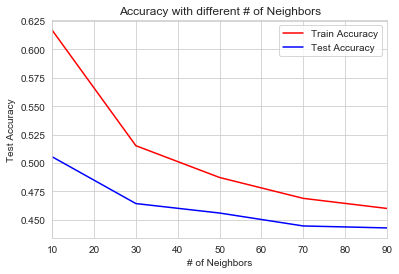

In [78]:
sns.lineplot(x = k, y = train_perf_k, color = 'red', label = "Train Accuracy")
sns.lineplot(x = k, y = test_perf_k, color = 'blue', label = "Test Accuracy")

plt.title('Accuracy with different # of Neighbors')
plt.xlabel('# of Neighbors')
plt.ylabel('Test Accuracy')
plt.xlim(10, 90)

In [ ]:
k = [90,95,100,105,110]

y_pred_train_ki = []
y_pred_test_ki = []

for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    y_pred_train_ki.append(classifier.predict(X_train))
    y_pred_test_ki.append(classifier.predict(X_test))
    
train_perf_k = []
test_perf_k = []

for i in y_pred_train_ki:
    train_perf_k.append(accuracy_score(y_true = y_train, y_pred = i))
for i in y_pred_test_ki:
    test_perf_k.append(accuracy_score(y_true = y_test, y_pred = i))

In [ ]:
train_perf_k

In [ ]:
test_perf_k

In [ ]:
for i in range(0,len(train_perf_k)):
    print(train_perf_k[i] - test_perf_k[i])

In [ ]:
sns.lineplot(x = k, y = train_perf_k, color = 'red', label = "Train Accuracy")
sns.lineplot(x = k, y = test_perf_k, color = 'blue', label = "Test Accuracy")

plt.title('Accuracy with different # of Neighbors')
plt.xlabel('# of Neighbors')
plt.ylabel('Test Accuracy')
plt.xlim(90, 110)

In [ ]:
cmtx_a_train = pd.DataFrame(
    confusion_matrix(y_true=y_train,y_pred = y_pred_train_ki[3], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

fig = plt.subplots(figsize = (14,10))

sns.heatmap(cmtx_a_train, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [ ]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_test_ki[3], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

fig = plt.subplots(figsize = (14,9))

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [ ]:
k = [115]

y_pred_train_ki = []
y_pred_test_ki = []

for i in k:
    classifier = KNeighborsClassifier(n_neighbors = i)
    classifier.fit(X_train, y_train)
    y_pred_train_ki.append(classifier.predict(X_train))
    y_pred_test_ki.append(classifier.predict(X_test))
    
train_perf_k = []
test_perf_k = []

for i in y_pred_train_ki:
    train_perf_k.append(accuracy_score(y_true = y_train, y_pred = i))
for i in y_pred_test_ki:
    test_perf_k.append(accuracy_score(y_true = y_test, y_pred = i))

In [ ]:
print(train_perf_k)
print(test_perf_k)

In [ ]:
cmtx_a_train = pd.DataFrame(
    confusion_matrix(y_true=y_train,y_pred = y_pred_train_ki[0], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

fig = plt.subplots(figsize = (14,10))

sns.heatmap(cmtx_a_train, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [ ]:
cmtx_a_test = pd.DataFrame(
    confusion_matrix(y_true=y_test,y_pred = y_pred_test_ki[0], labels = ['FY', 'FM', 'FO', 'MY', 'MM', 'MO'], normalize = 'true'),
    index=['true:FY', 'true:FM', 'true:FO', 'true:MY', 'true:MM', 'true:MO'], 
    columns=['pred:FY', 'pred:FM', 'pred:FO', 'pred:MY', 'pred:MM', 'pred:MO'])

fig = plt.subplots(figsize = (14,10))

sns.heatmap(cmtx_a_test, annot=True, fmt = '.02%', annot_kws={"size": 14}, vmin = 0, vmax = 1)

In [ ]:
allDone()